In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import seaborn as sns
from random import shuffle, randint
from tqdm import tqdm
from sklearn.neighbors import BallTree,KDTree
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import radians
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
from scipy.spatial import distance_matrix
from verstack.stratified_continuous_split import scsplit
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.inspection import permutation_importance
from pyproj import Proj, transform


from keras import Model
from tensorflow import keras
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from random import randint
from sklearn.ensemble import VotingRegressor
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from math import radians,degrees

import folium
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

import pickle


Using TensorFlow backend.


In [2]:
DEPARTMENT = 75

In [3]:
df = pd.read_csv('../Datas/Processed_data/{}.csv'.format(DEPARTMENT))
df['longitude_real'] = df.longitude.apply(degrees)
df['latitude_real'] = df.latitude.apply(degrees)

In [4]:
df

,id_mutation,nature_mutation,valeur_fonciere,code_postal,code_commune,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,type_local_str,year,quarter,month,Prix_m2_bati,Prix_m2_total,arrondissement,dist_min_lycee,type_plus_proche_lycee,dist_min_5_lycee,dist_min_maternelle,dist_min_ecoles_elementaires,dist_min_colleges,dist_min_5_colleges,dist_min_sup,dist_min_5_sup,dist_min_supermarche,dist_min_boulangerie,dist_min_boucherie,dist_min_poste,dist_min_pharmacie,dist_min_aeroport,dist_min_culture,dist_min_generaliste,dist_min_banque,dist_min_urgence,dist_min_specialiste,dist_min_dent,dist_min_infirimier,dist_min_creche,dist_min_gare,voisinage,voisinage_total,mean_dist_5_NN,mean_dist_10_NN,mean_dist_20_NN,mean_dist_25_NN,mean_dist_50_NN,mean_dist_75_NN,mean_dist_100_NN,std_dist_5_NN,std_dist_10_NN,std_dist_20_NN,std_dist_25_NN,std_dist_50_NN,std_dist_75_NN,std_dist_100_NN,Distance_plus_proche_ferré,Distance_moyenne_5_plus_proches_ferrés,Distance_moyenne_10_plus_proches_ferrés,Type_plus_proche_ferré,ligne_plus_proche_ferré,Noctilien_plus_proche,Distance_plus_proche_bus,Distance_moyenne_5_plus_proches_bus,Distance_moyenne_10_plus_proches_bus,std_distance_5_plus_proches_bus,std_distance_10_plus_proches_bus,longitude_real,latitude_real
0,2014-1054425,Vente,1250000.0,75008.0,75056,75,0.0,114.0,4,0.0,0.040288,0.852958,Appartement,2014,1,1,10964.912281,10964.912281,8,0.168340,C302,0.643823,0.791114,0.172569,0.106069,0.846481,0.187429,0.295854,107.515472,106.419667,106.501117,106.420009,107.138342,266.287453,123.765516,119.996715,107.222714,133.543973,106.647119,109.258863,106.513285,106.431554,106.971176,9593.562438,9593.562438,0.000000e+00,1.703390e-06,3.932557e-06,0.000005,0.000005,0.000005,0.000005,0.000000e+00,2.194314e-06,0.000003,0.000003,0.000003,0.000003,0.000003,0.137721,0.333028,0.519953,Metro,1,0.168522,0.133704,0.164488,0.189298,0.026800,0.033831,2.308322,48.870913
1,2014-1054427,Vente,366300.0,75008.0,75056,75,0.0,28.0,2,0.0,0.040520,0.853152,Appartement,2014,1,1,13082.142857,13082.142857,8,0.147183,C301,0.410922,0.385916,0.121931,0.147183,0.419904,0.016359,0.263712,108.627507,107.367028,107.492862,107.358249,108.220159,267.819703,123.935354,121.412289,108.005959,133.536105,107.670268,109.893862,107.403177,107.393937,107.782605,9078.464286,9078.464286,2.885431e-06,4.692900e-06,6.972175e-06,0.000008,0.000008,0.000008,0.000008,1.515831e-06,2.311926e-06,0.000003,0.000003,0.000003,0.000003,0.000003,0.036268,0.362181,0.466640,Metro,2,0.069778,0.059450,0.086486,0.146442,0.022134,0.066306,2.321644,48.882009
2,2014-1054428,Vente,290000.0,75008.0,75056,75,0.0,30.0,1,0.0,0.040149,0.853058,Appartement,2014,1,1,9666.666667,9666.666667,8,0.522148,C301,0.652477,0.495576,0.421676,0.466684,0.846578,0.044177,0.134745,107.011232,105.823236,105.927426,105.819076,106.615471,266.612289,122.935672,119.751357,106.553223,132.694226,106.090397,108.535965,105.889405,105.842662,106.313110,12200.703408,12200.703408,0.000000e+00,1.509214e-06,5.320604e-06,0.000006,0.000007,0.000007,0.000007,0.000000e+00,3.018427e-06,0.000004,0.000004,0.000004,0.000004,0.000004,0.214275,0.354706,0.513813,Metro,2,0.059506,0.042594,0.113931,0.164537,0.053174,0.066703,2.300376,48.876606
3,2014-1054429,Vente,450000.0,75001.0,75056,75,0.0,60.0,2,0.0,0.040772,0.852886,Appartement,2014,1,1,7500.000000,7500.000000,1,0.322336,C301,0.609157,0.245463,0.195366,0.257943,0.918803,0.206487,0.244110,109.481877,108.460598,108.526523,108.463763,109.122139,266.748777,125.724945,121.631273,109.297335,135.413096,108.659638,111.336947,108.570021,108.467569,109.042419,13175.601044,13175.601044,4.725994e-07,1.544683e-06,3.147356e-06,0.000004,0.000004,0.000004,0.000004,9.451988e-07,1.266536e-06,0.000002,0.000002,0.000002,0.000002,0.000002,0.154803,0.296039,0.404563,Metro,7,0.307502,0.044401,0.116684,0.134594,0.036784,0.032611,2.336053,48.866790
4,2014-1054430,Vente,210000.0,75001.0,75056,75,0.0,20.0,1,0.0,0.040845,0.852814,Appartement,2014,1

In [5]:
df.dropna(inplace=True)
df = df[(df.Prix_m2_bati> 1000) & (df.Prix_m2_bati < 25000)].reset_index(drop=True)

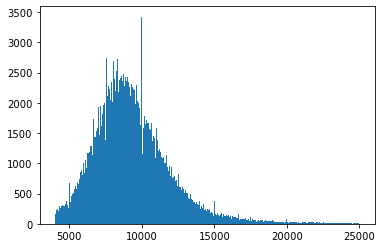

In [6]:
plt.hist(df.Prix_m2_bati,bins = 300);

# Adding specific datas : 

In [7]:
def rectify_code_commune(x) : 
    return int(x)  + 100
df.code_commune = df.code_postal.apply(rectify_code_commune)

In [8]:
def add_speficic_datas(df) : 
    
    print("Now, adding economical datas about employement and demography per arrondissement...")
    
    df_arr = pd.read_excel('../Datas/Raw_data/FILOSOFI_datasets/pauvrete_2018.xlsx')
    df_arr = df_arr[df_arr['Code géographique'].isin(df.code_commune.astype(str))].reset_index(drop=True).drop(
                    columns = ['Libellé géographique']).rename(columns = {'Code géographique' : 'code_commune'})
    
    df.code_commune = df.code_commune.astype(str)
    df = df.merge(df_arr,on='code_commune',how='left')
    
    print("Done.")
    
    
    
    return df

In [9]:
df = add_speficic_datas(df)

Now, adding economical datas about employement and demography per arrondissement...
Done.


# Plot heat map of the price on the target city : 

In [10]:
df['longitude_real'] = df.longitude.apply(degrees)
df['latitude_real'] = df.latitude.apply(degrees)

In [11]:
# Takes a lot of memory, increase nb_plots for more details
# Static map after that

center = [48.856614, 2.3522219]
nb_plots = 1e3

hmap = folium.Map(location= center, zoom_start=12)

max_price = float(df['Prix_m2_bati'].max())
min_price = float(df['Prix_m2_bati'].min())
colormap = cm.LinearColormap(colors=['lightblue','red'], vmin=min_price,vmax=max_price)



lat = list(df.loc[:nb_plots].latitude_real)
lon = list(df.loc[:nb_plots].longitude_real)
price = list(df.loc[:nb_plots].Prix_m2_bati)


for loc, p in tqdm(zip(zip(lat, lon), price)):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(p),
    ).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

1001it [00:00, 9898.36it/s]


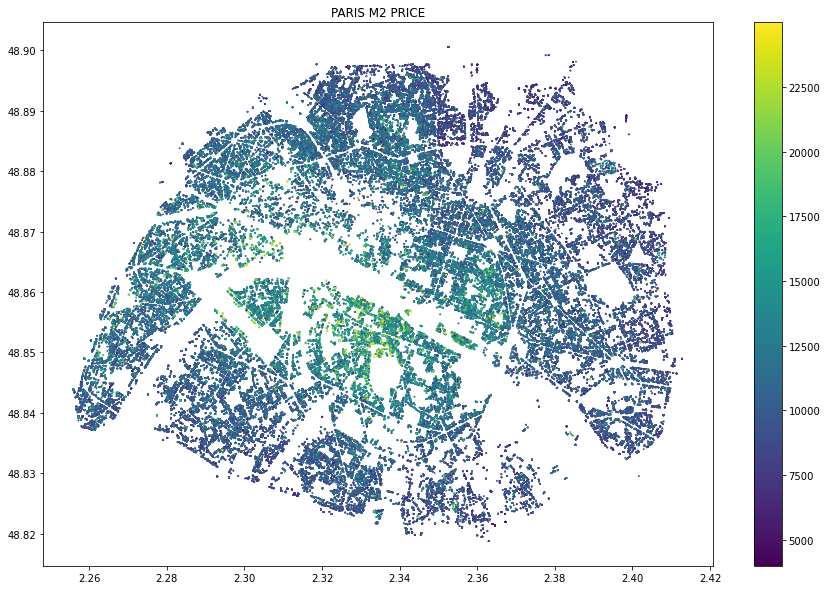

In [12]:
plt.figure(figsize = (15,10))
plt.scatter(df.longitude_real.values,df.latitude_real.values, c = df.Prix_m2_bati.values,s=2*df.Prix_m2_bati.values/df.Prix_m2_bati.values.max())
plt.colorbar()
plt.title('PARIS M2 PRICE')
plt.show()

In [20]:
def evaluate_model(y_test,y_pred):
    error= np.abs((y_test-y_pred)/y_test)*100
    print('Mean absolute percentage error = {}'.format(np.mean(error)))
    print('Median absolute percentage error = {}'.format(np.median(error)))

In [13]:
X_train, X_test, Y_train, Y_test = scsplit(df,df.Prix_m2_bati,test_size = 0.2,train_size = 0.8,stratify = df.Prix_m2_bati,random_state=10)

In [14]:
index_train = X_train.index
index_test = X_test.index

prix_m2_train = Y_train.values
prix_m2_test = Y_test.values
vf_train = df.loc[index_train].valeur_fonciere
vf_test = df.loc[index_test].valeur_fonciere

In [15]:
categorical_features = ['nombre_pieces_principales','type_local', 'ligne_plus_proche_ferré',
                       'year','arrondissement','quarter']

quantitative_features = [
 'surface_reelle_bati',
 'surface_terrain',
 'dist_min_lycee',
 'dist_min_5_lycee',
 'dist_min_maternelle',
 'dist_min_ecoles_elementaires',
 'dist_min_colleges',
 'dist_min_5_colleges',
 'dist_min_sup',
 'dist_min_5_sup',
 'dist_min_supermarche',
 'dist_min_boulangerie',
 'dist_min_boucherie',
 'dist_min_poste',
 'dist_min_pharmacie',
 'dist_min_aeroport',
 'dist_min_culture',
 'dist_min_generaliste',
 'dist_min_banque',
 'dist_min_urgence',
 'dist_min_specialiste',
 'dist_min_dent',
 'dist_min_infirimier',
 'dist_min_creche',
 'dist_min_gare',
 'voisinage',
 'voisinage_total',
 'mean_dist_5_NN',
 'Distance_plus_proche_ferré',
 'Noctilien_plus_proche',
 'Distance_plus_proche_bus',
'Médiane du niveau vie (€)',
 'Taux de pauvreté-40 à 49 ans (%)',
 'Taux de pauvreté-60 à 74 ans (%)',
 'Taux de pauvreté-locataires (%)',
 "Part des revenus d'activité (%)",
 'dont part des revenus des activités non salariées (%)',
 'Part des revenus du patrimoine et autres revenus (%)',
 "Part de l'ensemble des prestations sociales (%)",
 'Part des impôts (%)']

cols = [categorical_features + quantitative_features]

with open('./models/features_{}.txt'.format(DEPARTMENT), "wb") as fp:  
    pickle.dump([categorical_features + quantitative_features], fp)


X_train = X_train[categorical_features + quantitative_features]
X_test = X_test[categorical_features + quantitative_features]

In [16]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [17]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])


In [18]:
MODEL.fit(X_train,Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local',
                                                   'ligne_plus_proche_ferré',
                                                   'year', 'arrondissement',
                                                   'quarter']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                   

In [21]:
predicted = MODEL.predict(X_test)
evaluate_model(Y_test,predicted)

Mean absolute percentage error = 15.84123436049212
Median absolute percentage error = 10.71020078749076


In [21]:
valeur_fonciere = vf_test
prediction_vf = predicted*X_test.surface_reelle_bati

In [22]:
evaluate_model(valeur_fonciere,prediction_vf)

Mean absolute percentage error = 15.841234360492123
Median absolute percentage error = 10.710200787490756


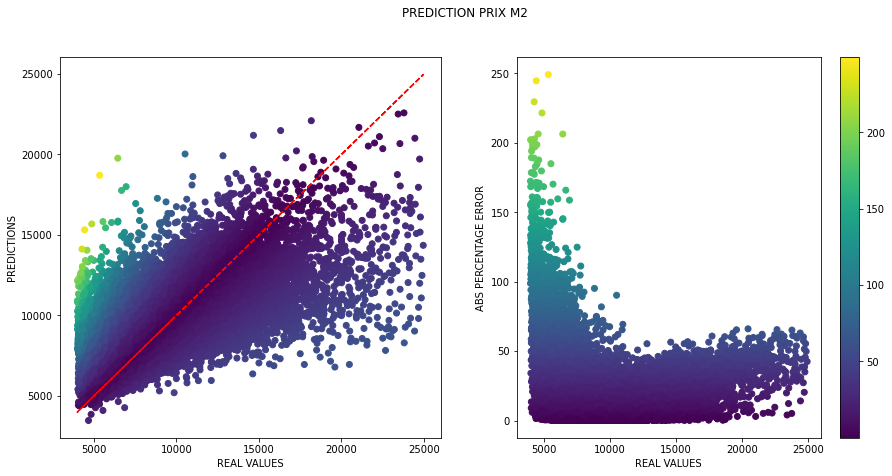

In [23]:
mape = np.abs((predicted - Y_test)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,predicted,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((predicted - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

Mean absolute percentage error = 15.841234360492123
Median absolute percentage error = 10.710200787490756


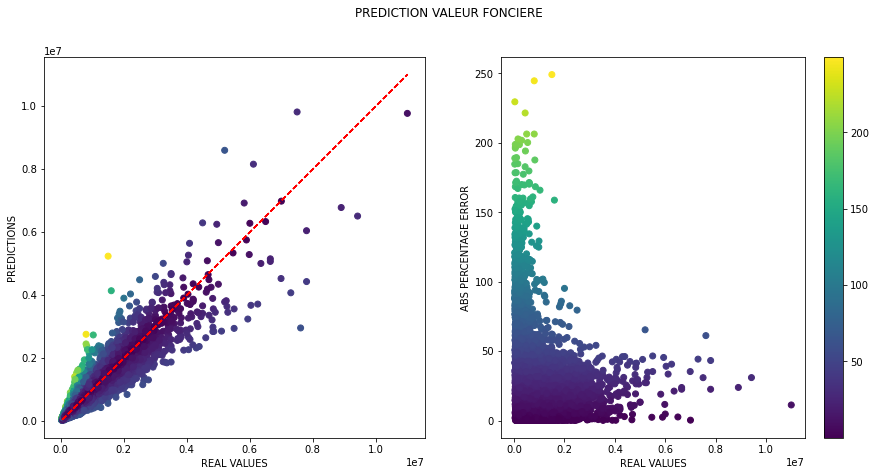

In [24]:
mape = np.abs((valeur_fonciere - prediction_vf)/valeur_fonciere)*100

evaluate_model(valeur_fonciere,prediction_vf)

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(valeur_fonciere,prediction_vf,c= mape)
plt.plot(valeur_fonciere,valeur_fonciere,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(valeur_fonciere,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar()

# Spatial distribution of the error : 

In [25]:
error = mape
hmap = folium.Map(location= center, zoom_start=12)

df_test = df[df.index.isin(index_test)] 
nb_plots = 1e3

max_error = max(error)
min_error = min(error)
mean_error = np.mean(error)
med_error = np.median(error)
colormap = cm.LinearColormap(colors=['lightblue','red'], index = [min_error,max_error],
                             vmin=min_error,vmax=max_error)



lat = list(df_test.reset_index().loc[:nb_plots].latitude_real)
lon = list(df_test.reset_index().loc[:nb_plots].longitude_real)
price = list(error)


for loc, p in tqdm(zip(zip(lat, lon), error)):
    folium.Circle(
        location=loc,
        radius=p,
        fill=True,
        color=colormap(p),
        fill_opacity=p/max_error).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

1001it [00:00, 3250.13it/s]


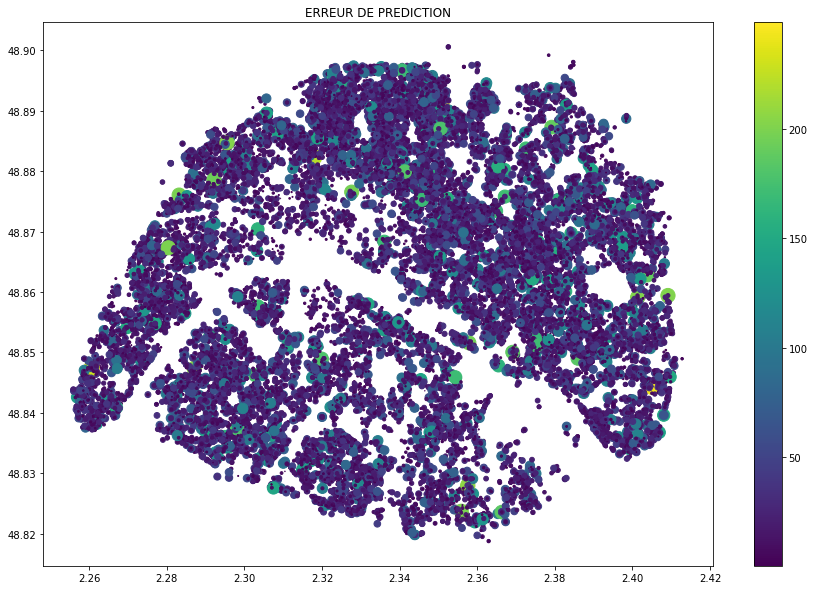

In [26]:
plt.figure(figsize = (15,10))
plt.scatter(df_test.longitude_real.values,df_test.latitude_real.values, c = error,s=error)
plt.colorbar()
plt.title('ERREUR DE PREDICTION')
plt.show()

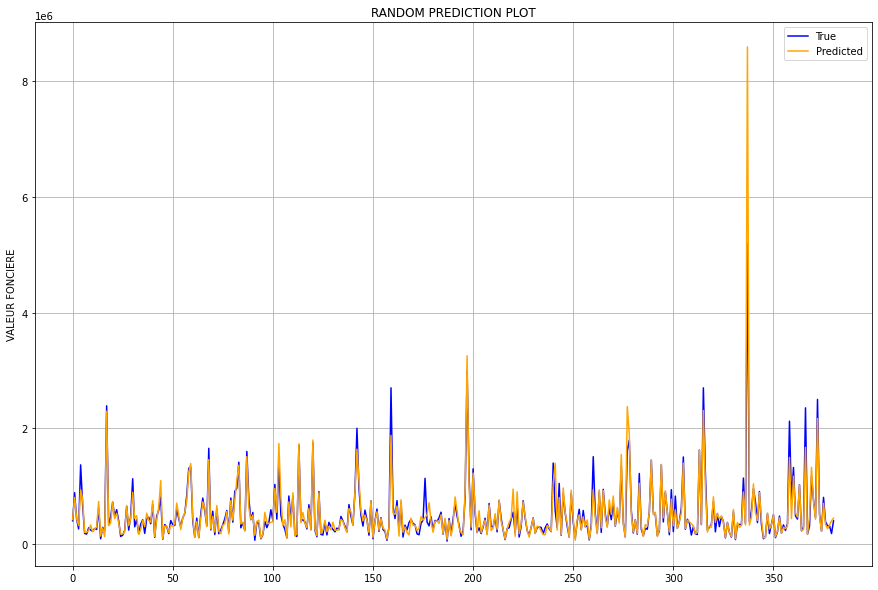

In [27]:
plt.figure(figsize=(15,10))
n = len(Y_test)
number = int(n/100)
array = np.arange(n)
shuffle(array)

i = randint(0,n-number)

prediction = prediction_vf
prediction_plot = []
true_plot = []

for indice in array[i:i+number]:
    true_plot.append(valeur_fonciere.values[indice])
    prediction_plot.append(prediction.values[indice])
    

plt.plot(range(number),true_plot,'b',label='True')
plt.plot(range(number),prediction_plot,'orange',label='Predicted')
plt.grid()
plt.title('RANDOM PREDICTION PLOT')
plt.ylabel('VALEUR FONCIERE')
plt.legend()

In [28]:
n_repeats = 5

feature_importances = permutation_importance(
    MODEL, X_test, Y_test, n_repeats=n_repeats
)

In [29]:
sorted_idx = feature_importances.importances_mean.argsort()[::-1]
names = X_test.columns.copy()

for i in range(len(names)):
    features = feature_importances.importances[sorted_idx].T[:,i]
    series = pd.Series(features)
    if i == 0 :
        dfa = pd.DataFrame(series,columns = ['Importance'])
        dfa['Features'] = np.array(names)[sorted_idx][i]
    else : 
        df2 = pd.DataFrame(series,columns = ['Importance'])
        df2['Features'] = np.array(names)[sorted_idx][i]
        dfa = pd.concat([dfa,df2])

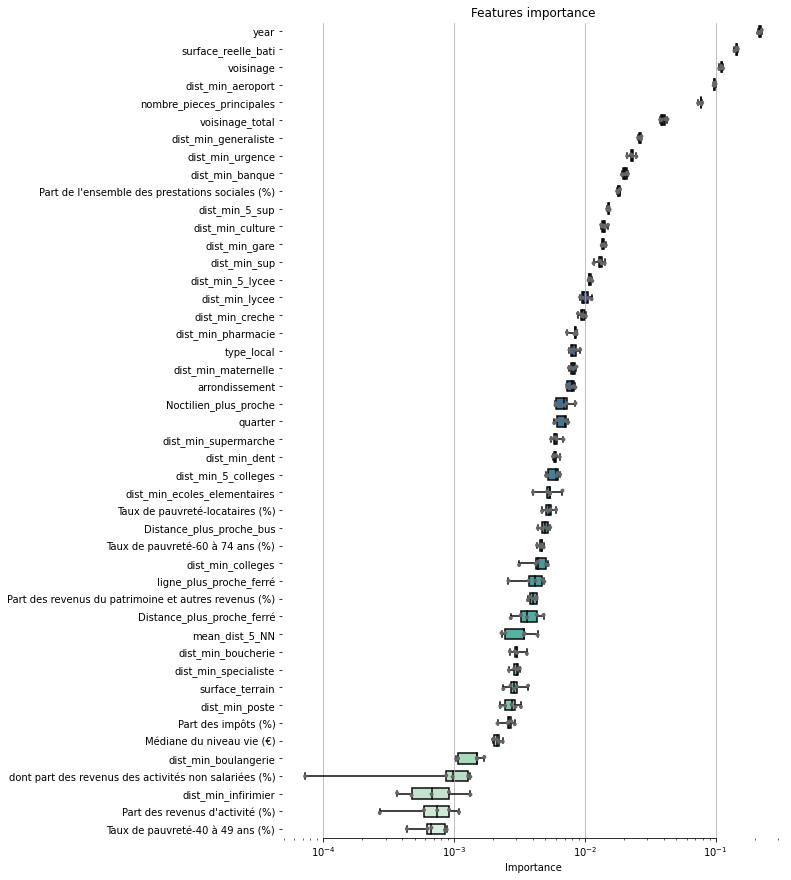

In [30]:
# Plot the orbital period with horizontal boxes

f, ax = plt.subplots(figsize=(9,15))
ax.set_xscale("log")
sns.boxplot(x='Importance', y='Features',data=dfa,
            whis=[0, 100], width=.6, palette="mako")


sns.stripplot(x='Importance', y='Features',data=dfa,
              size=4, color=".4", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_title('Features importance');

# Neural Network

In [31]:
X_pre_train = X_train.copy()
X_pre_test = X_test.copy()
Y_train = prix_m2_train
Y_test = prix_m2_test

In [32]:
X_train_keras = preprocessor.transform(X_pre_train[categorical_features + quantitative_features])
X_test_keras = preprocessor.transform(X_pre_test[categorical_features + quantitative_features])

In [33]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [67]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_train_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [68]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [69]:
keras_regressor.fit(X_train_keras,Y_train,callbacks=[callback],validation_split=0.2)

Train on 121938 samples, validate on 30485 samples
Epoch 1/1500
121938/121938 [==============================] - 3s 28us/step - loss: 14993819.9857 - val_loss: 4674659.1102
Epoch 2/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4485341.0370 - val_loss: 4612368.2968
Epoch 3/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4437755.2165 - val_loss: 4516315.7433
Epoch 4/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4408748.8238 - val_loss: 4490177.7851
Epoch 5/1500
121938/121938 [==============================] - 2s 19us/step - loss: 4406231.2528 - val_loss: 4485216.1494
Epoch 6/1500
121938/121938 [==============================] - 3s 25us/step - loss: 4390747.8681 - val_loss: 4739871.4402
Epoch 7/1500
121938/121938 [==============================] - 3s 25us/step - loss: 4377326.3313 - val_loss: 4553491.0701
Epoch 8/1500
121938/121938 [==============================] - 3s 25us/step - loss: 4367477.4368 - val

Epoch 68/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4236635.2176 - val_loss: 4398089.0399
Epoch 69/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4231830.7648 - val_loss: 4389949.0577
Epoch 70/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4241474.5313 - val_loss: 4373297.7539
Epoch 71/1500
121938/121938 [==============================] - 2s 20us/step - loss: 4229993.0502 - val_loss: 4372098.3343
Epoch 72/1500
121938/121938 [==============================] - 3s 22us/step - loss: 4230422.8175 - val_loss: 4403636.3676
Epoch 73/1500
121938/121938 [==============================] - 3s 25us/step - loss: 4230391.8520 - val_loss: 4356821.4651
Epoch 74/1500
121938/121938 [==============================] - 3s 25us/step - loss: 4227312.5825 - val_loss: 4374821.1261
Epoch 75/1500
121938/121938 [==============================] - 3s 21us/step - loss: 4222741.3796 - val_loss: 4382457.9727
Epoch 76/1500
121938/121

In [70]:
prediction = keras_regressor.predict(X_test_keras)
evaluate_model(prediction,Y_test)

38106/38106 [==============================] - 0s 7us/step
Mean absolute percentage error = 14.982579192154065
Median absolute percentage error = 11.0706718831183


In [71]:
prediction_vf = prediction*X_test.surface_reelle_bati
evaluate_model(prediction_vf,vf_test)

Mean absolute percentage error = 14.982579192154132
Median absolute percentage error = 11.070671883118294


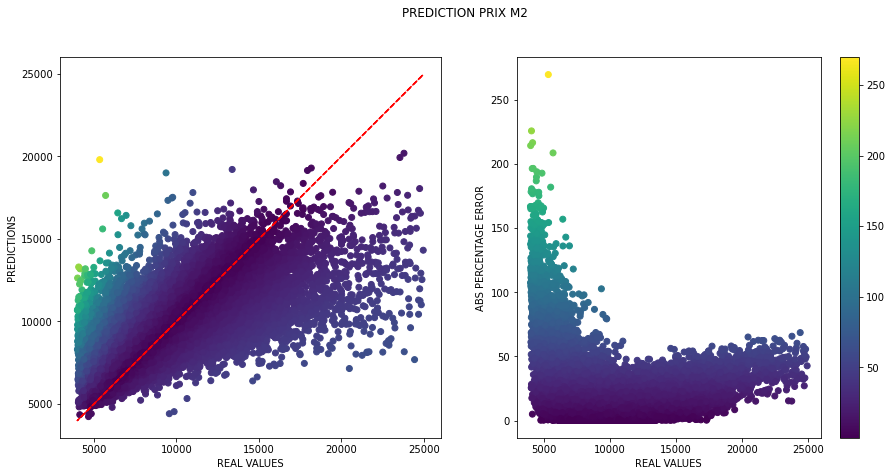

In [72]:
mape = np.abs((prediction - Y_test)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,prediction,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((prediction - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

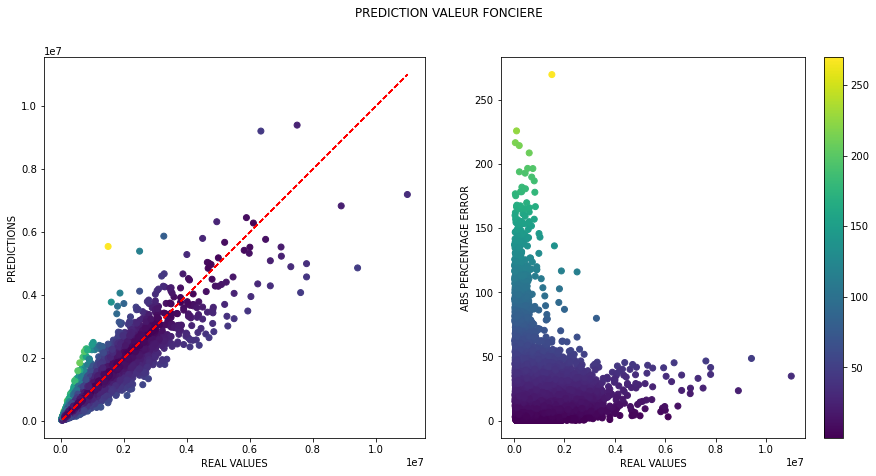

In [73]:
mape = np.abs((vf_test - prediction_vf)/vf_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(vf_test,prediction_vf,c= mape)
plt.plot(vf_test,vf_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(vf_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar();

# MIXED MODEL 

In [74]:
mixed = np.average([prediction,predicted],axis=0,weights=[0.5,0.5])
evaluate_model(mixed,Y_test)

Mean absolute percentage error = 14.532902073999196
Median absolute percentage error = 10.714697292063786


In [75]:
part_keras = np.linspace(0,1,101)
list_mape = []
min_loss = np.inf 
best_tradeoff = 0
best_mixed = mixed

for i in part_keras : 
    mixed = np.average([prediction,predicted],axis=0,weights=[i,1-i])
    mae = np.mean(np.abs(mixed-Y_test))
    list_mape.append(mae)
    if mae < min_loss : 
        best_tradeoff = i 
        min_loss = mae
        best_mixed = mixed
        

Text(0.5, 1.0, 'BEST PART KERAS : 0.37')

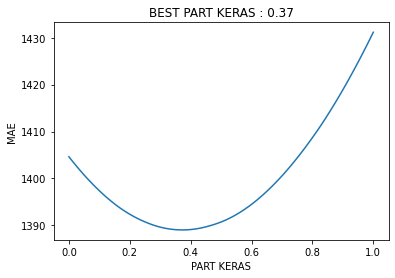

In [76]:
plt.figure()
plt.plot(part_keras,list_mape)
plt.ylabel('MAE')
plt.xlabel('PART KERAS')
plt.title('BEST PART KERAS : {}'.format(best_tradeoff))

In [77]:
evaluate_model(best_mixed,Y_test)

Mean absolute percentage error = 14.513180931816535
Median absolute percentage error = 10.685538402522578


In [78]:
Boundary = 30

ap_error = (np.abs(best_mixed - Y_test)/Y_test)*100
print("Prediction with less than {}% error represents {}% of predictions.".format(Boundary,(1 - (len(Y_test) - sum(ap_error < Boundary))/len(Y_test))*100))

Prediction with less than 30% error represents 87.57675956542276% of predictions.


# Make the true training of the two models, save optimal tradeoff

In [22]:
X = df[categorical_features + quantitative_features]
Y = df.Prix_m2_bati

In [23]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [24]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])

In [25]:
MODEL.fit(X,Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local',
                                                   'ligne_plus_proche_ferré',
                                                   'year', 'arrondissement',
                                                   'quarter']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                   

In [26]:
X_keras = preprocessor.transform(X)

In [27]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [28]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [29]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [30]:
keras_regressor.fit(X_keras,Y,callbacks=[callback],validation_split=0.2)

Train on 152423 samples, validate on 38106 samples
Epoch 1/1500
152423/152423 [==============================] - 9s 57us/step - loss: 2271.4233 - val_loss: 2040.7234
Epoch 2/1500
152423/152423 [==============================] - 7s 47us/step - loss: 1431.9076 - val_loss: 2080.0086
Epoch 3/1500
152423/152423 [==============================] - 8s 55us/step - loss: 1425.9967 - val_loss: 2080.9062
Epoch 4/1500
152423/152423 [==============================] - 9s 56us/step - loss: 1421.7940 - val_loss: 2093.1859
Epoch 5/1500
152423/152423 [==============================] - 9s 57us/step - loss: 1419.0952 - val_loss: 2103.3953
Epoch 6/1500
152423/152423 [==============================] - 8s 54us/step - loss: 1416.5215 - val_loss: 2111.6787
Epoch 7/1500
152423/152423 [==============================] - 9s 57us/step - loss: 1416.7148 - val_loss: 2059.4925
Epoch 8/1500
152423/152423 [==============================] - 6s 40us/step - loss: 1413.9864 - val_loss: 2071.0563
Epoch 9/1500
152423/152423 [=

# Saving models

In [31]:
filename = './models/Pipeline_LGBM_{}.sav'.format(DEPARTMENT)
pickle.dump(MODEL, open(filename, 'wb'))

In [32]:
filename = './models/preprocessor_keras_{}.sav'.format(DEPARTMENT)
pickle.dump(preprocessor, open(filename, 'wb'))

In [33]:
filename = './models/keras_{}.h5'.format(DEPARTMENT)
keras_regressor.model.save(filename)